In [206]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from utils.generate_graph import loss_vs_epoch
from utils.models import GCN_t1, GCN_t2 

In [207]:
def test(model, data, device):
    model.eval()

    data = data.to(device)
    _, pred = model(data).max(dim=1)
    correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
    acc = correct / int(data.test_mask.sum())

    print(f'Test accuracy: {acc}')

In [208]:
import numpy as np
import torch

def validate_cel(model, data, cel, device):
    total = 0
    correct = 0
    results = []

    with(torch.set_grad_enabled(False)):
        data.to(device)
        x = model(data)[data.val_mask]
        results.append(cel(x, data.y[data.val_mask]))

        value, pred = torch.max(x, 1)
        total += float(x.size(0))
        correct += pred.eq(data.y[data.val_mask]).sum().item()

    return sum(results) / len(results), correct * 100. / total


def get_predicted_actual(model, data):
    predicted = []
    actual = []

    for i, (images, labels) in enumerate(data):
        images = images.cuda()
        x = model(images)
        value, pred = torch.max(x, 1)
        pred = pred.data.cpu()

        predicted.extend(list(pred.numpy()))
        actual.extend(list(labels.numpy()))

    return np.array(predicted), np.array(actual)

In [209]:
import time
from torch import nn, optim, cuda
import matplotlib.pyplot as plt

LEARNING_RATE = 0.001
EPOCHS = 200
WEIGHT_DECAY = 5e-4

def train(model, device, data):
    time_start = time.time()

    accuracies = []
    training_losses = []
    validation_losses = []
    max_accuracy = 0

    cel = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    model.train()
    for epoch in range(EPOCHS):
        cuda.empty_cache()

        data.to(device)
        pred = model(data)[data.train_mask]
        loss = cel(pred, data.y[data.train_mask])

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        training_loss = float(loss)
        training_losses.append(training_loss)

        validation_loss, accuracy = validate_cel(model, data, cel, device)
        validation_losses.append(validation_loss.cpu())
        accuracies.append(accuracy)

        if accuracy > max_accuracy:
            best_model = model
            max_accuracy = accuracy

        print(
            f'Epoch: {epoch + 1}, Accuracy: {accuracy}%, Training loss: {training_loss}, Validation loss: {validation_loss}')

    time_end = time.time()
    print(f'Training complete. Time elapsed: {time_end - time_start}s')

    print(f'Saving best model with accuracy: {max_accuracy}')
    # save_to_file(best_model, f'model_acc_{max_accuracy}_ep_{EPOCHS}')

    plt.plot(accuracies, label='Accuracy')
    
    plt.legend()
    plt.show()

    plt.cla()
    plt.plot(training_losses, label='Training losses')
    halt = accuracies.index(max(accuracies))
    plt.axvline(x=halt, color='r', linestyle="--", label="stop training")
    plt.plot(validation_losses, label='Validation losses')
    plt.legend()
    plt.show()

    return best_model

In [210]:
def normalized_cut_2d(edge_index, pos):
    row, col = edge_index
    edge_attr = torch.norm(pos[row] - pos[col], p=2, dim=1)
    return normalized_cut(edge_index, edge_attr, num_nodes=pos.size(0))

In [211]:
class GCN(torch.nn.Module):
    def __init__(self, dataset):
        super(GCN, self).__init__()

        self.conv1 = GCNConv(dataset.num_node_features, 512)
        self.conv2 = GCNConv(512, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

Epoch: 1, Accuracy: 36.4%, Training loss: 1.934078574180603, Validation loss: 1.889117956161499
Epoch: 2, Accuracy: 52.4%, Training loss: 1.854032039642334, Validation loss: 1.8503457307815552
Epoch: 3, Accuracy: 62.6%, Training loss: 1.7683141231536865, Validation loss: 1.8098262548446655
Epoch: 4, Accuracy: 65.6%, Training loss: 1.692831039428711, Validation loss: 1.7759300470352173
Epoch: 5, Accuracy: 69.2%, Training loss: 1.6047865152359009, Validation loss: 1.7322542667388916
Epoch: 6, Accuracy: 71.0%, Training loss: 1.5202600955963135, Validation loss: 1.689846396446228
Epoch: 7, Accuracy: 73.6%, Training loss: 1.4387719631195068, Validation loss: 1.6428794860839844
Epoch: 8, Accuracy: 73.6%, Training loss: 1.355305552482605, Validation loss: 1.5980881452560425
Epoch: 9, Accuracy: 74.8%, Training loss: 1.2639188766479492, Validation loss: 1.5411282777786255
Epoch: 10, Accuracy: 77.6%, Training loss: 1.1835821866989136, Validation loss: 1.4920121431350708
Epoch: 11, Accuracy: 75.0

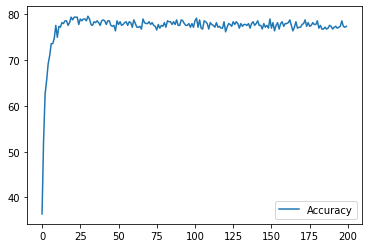

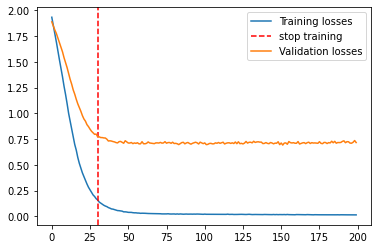

Test accuracy: 0.801


In [212]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid("data", "Cora")
# Get the first and only graph
data = dataset[0]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GCN(dataset).to(device)

model = train(model, device=device, data=data)

test(model, data=data, device=device)

In [213]:
print(model)

GCN(
  (conv1): GCNConv(1433, 512)
  (conv2): GCNConv(512, 7)
)


In [214]:
import networkx as nx
import matplotlib.pyplot as plt
import torch
from torch_geometric.utils.convert import to_networkx

In [215]:
def visualize_t(dataset):
    graph = to_networkx(dataset[0])

    node_labels = dataset[0].y[list(graph.nodes)].numpy()

    import matplotlib.pyplot as plt
    plt.figure(1, figsize=(16, 16))
    nx.draw(graph, cmap=plt.get_cmap('Set1'), node_color=node_labels, node_size=25, linewidths=3)
    plt.show()

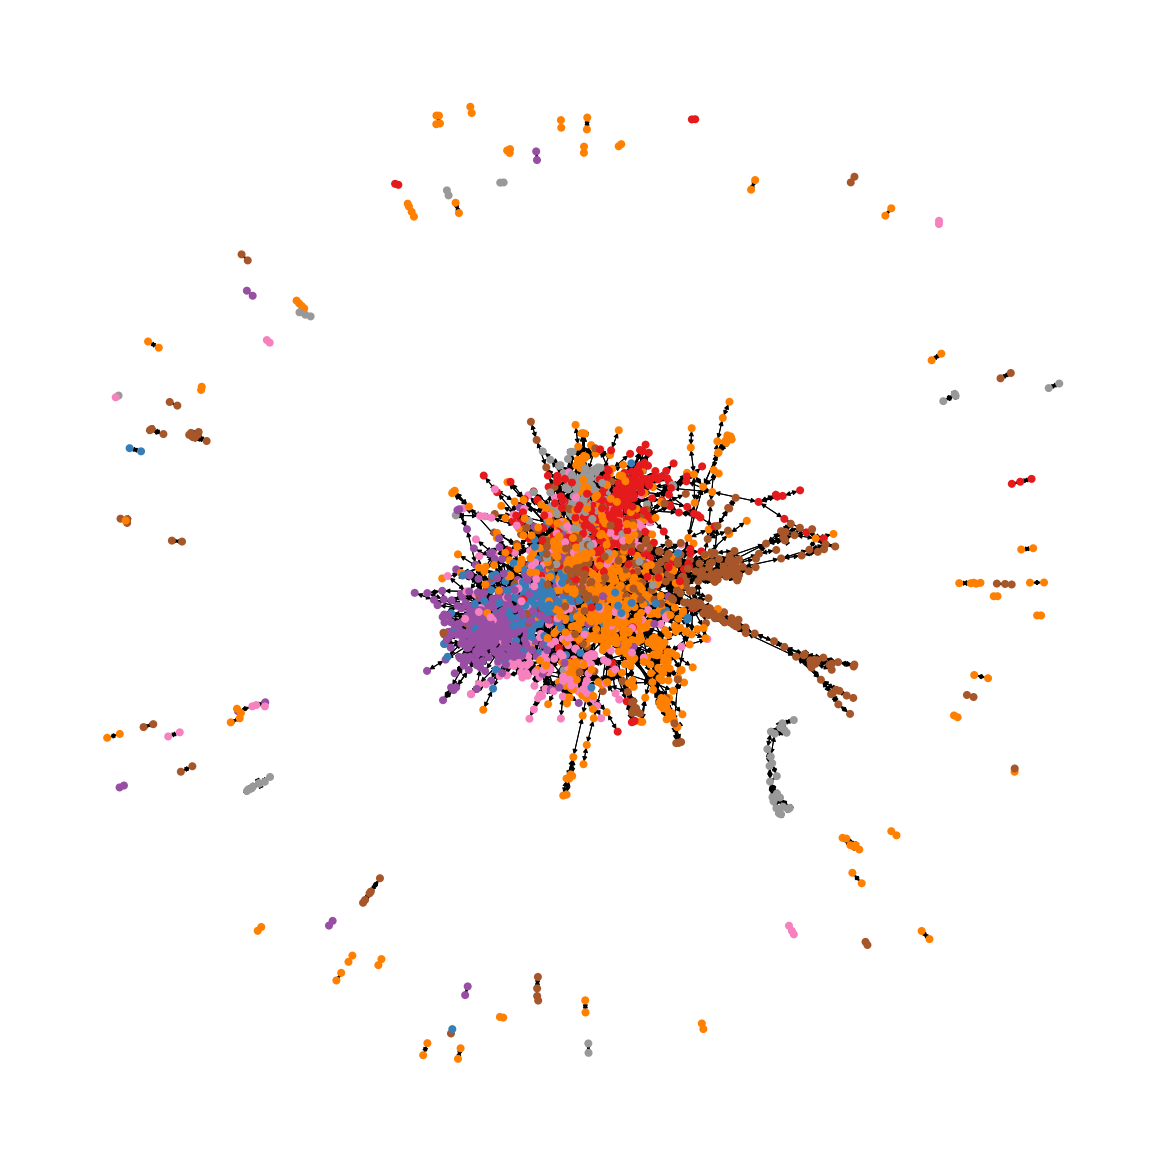

In [216]:
visualize_t(dataset)